In [38]:
import arviz as az

In [39]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI

from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings("ignore")
sns.set_style("white")

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)
# from tueplots import bundles
# bundles.icml2022() 
# plt.rcParams.update(bundles.icml2022())

layer_names = ["w1_c", "w2_c", "w3_c"]

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': r'\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

latexify()

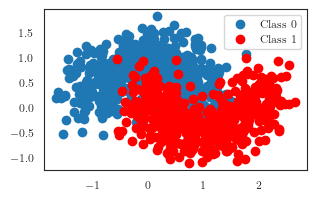

In [41]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
# sns.despine()
plt.legend()

In [42]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

Defining the dataset so to keep common for both BNN and CNP

X_train_final and Y_train_final - fixed angles whose datapoints are not changing

Y_test_final and X_test_final - data corresponding to the angle whose points are going to change. use to calculate the accuracy 

contexts_x - varying number of points for the last angle

In [43]:

context_points = list(range(10, 101, 10))
# context_points = [10, 20]

n_samples = 100
angles = [0, 45, 90, 135, 180, 225, 270, 315]

noise = 0.2

# fixed points
X_train_data, Y_train_data = [], []
X_test_data, Y_test_data = [], []
angle_param = []
for i in range(len(angles)):
    xx, yy = make_moons(n_samples=n_samples, noise= noise)
    rotate_by = angles[i]
    angle_param.append(np.ones([n_samples,1])*np.sin(angles[i]))
    if i == len(angles) - 1:
        X_test_data = rotate(xx, rotate_by)
        Y_test_data = yy
    else :
        X_train_data.append(rotate(xx, rotate_by))
        Y_train_data.append(yy)

# different context
contexts_x, contexts_y = [], []
for contexts in context_points:
    x_new = np.tile(X_test_data[: contexts], (n_samples//contexts +1, 1))
    y_new = np.tile(Y_test_data[: contexts], n_samples//contexts + 1)
    x_new = x_new[: n_samples, :]
    y_new = y_new[: n_samples]
    contexts_x.append(x_new)
    contexts_y.append(y_new)

contexts_y = np.array(contexts_y)
contexts_x = np.array(contexts_x)
X_train_data = np.array(X_train_data)
Y_train_data = np.array(Y_train_data)
X_test_data = np.array(X_test_data)
Y_test_data = np.array(Y_test_data)
angle_param = np.array(angle_param)

In [44]:
contexts_x.shape, contexts_y.shape, X_test_data.shape, Y_test_data.shape, X_train_data.shape, Y_train_data.shape, angle_param.shape


((10, 100, 2), (10, 100), (100, 2), (100,), (7, 100, 2), (7, 100), (8, 100, 1))

In [45]:
# # Saving the datasets
# np.save('datasets/contexts_y.npy', contexts_y)
# np.save('datasets/contexts_x.npy', contexts_x)
# np.save('datasets/X_train_data.npy', X_train_data)
# np.save('datasets/Y_train_data.npy', Y_train_data)
# np.save('datasets/X_test_data.npy', X_test_data)
# np.save('datasets/Y_test_data.npy', Y_test_data)

In [46]:
contexts_x[0, :30]

array([[ 1.20519078,  1.62506349],
       [ 1.37663775,  1.01702593],
       [-0.26489823,  0.14477466],
       [ 0.06581748,  0.61797357],
       [ 1.17452756,  0.36533052],
       [-1.17539597, -0.89952036],
       [ 0.68894375,  0.17609912],
       [ 0.51967912,  0.80194027],
       [ 0.03618611,  0.93379605],
       [ 0.13718101,  0.09612275],
       [ 1.20519078,  1.62506349],
       [ 1.37663775,  1.01702593],
       [-0.26489823,  0.14477466],
       [ 0.06581748,  0.61797357],
       [ 1.17452756,  0.36533052],
       [-1.17539597, -0.89952036],
       [ 0.68894375,  0.17609912],
       [ 0.51967912,  0.80194027],
       [ 0.03618611,  0.93379605],
       [ 0.13718101,  0.09612275],
       [ 1.20519078,  1.62506349],
       [ 1.37663775,  1.01702593],
       [-0.26489823,  0.14477466],
       [ 0.06581748,  0.61797357],
       [ 1.17452756,  0.36533052],
       [-1.17539597, -0.89952036],
       [ 0.68894375,  0.17609912],
       [ 0.51967912,  0.80194027],
       [ 0.03618611,

In [47]:
"""
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
"""


def hierarchical_nn(X, Y, D_H ):
    # D_C, _, D_X = X.shape
    # D_Y = 1

    D_Y = 1 # output dim
    D_C = 8 # different tasks
    D_X = 2 # input dimensions
    # print(X.shape)
    # Group mean distribution for input to hidden layer
    mu_1= numpyro.sample("mu_1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    sigma_1 = numpyro.sample("sigma_1", dist.HalfNormal(1.0))

    # sample second layer
    mu_2 = numpyro.sample("mu_2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    sigma_2 = numpyro.sample("sigma_2", dist.HalfNormal(1.0))

    # sample final layer of weights and neural network output
    mu_3 = numpyro.sample("mu_3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    sigma_3 = numpyro.sample("sigma_3", dist.HalfNormal(1.0))

    w1_all = numpyro.sample("w1_all", dist.Normal(jnp.zeros((D_C, D_X, D_H)), jnp.ones((D_C, D_X, D_H))))  # D_C D_X D_H
    w2_all = numpyro.sample("w2_all", dist.Normal(jnp.zeros((D_C, D_H, D_H)), jnp.ones((D_C, D_H, D_H))))  # D_C D_H D_H
    w3_all = numpyro.sample("w3_all", dist.Normal(jnp.zeros((D_C, D_H, D_Y)), jnp.ones((D_C, D_H, D_Y))))  # D_C D_H D_Y

    w1 = w1_all * sigma_1 + mu_1
    w2 = w2_all * sigma_2 + mu_2
    w3 = w3_all * sigma_3 + mu_3

    # print(f"shape - w1 w2 w3 {w1.shape, w2.shape, w3.shape}") # w1 shape = D_C * D_X * D_H
    z1 = jnp.tanh(jnp.matmul(X, w1))  # D_C N D_H  <= first layer of activations
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # D_C N D_H  <= second layer of activations
    z3 = jnp.matmul(z2, w3)  # D_C N D_Y  <= output of the neural network

    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y.reshape((D_C, -1, 1)) if Y is not None else Y)


In [49]:
def run_inference(model, rng_key, args, **kwargs):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        progress_bar=True,
    )
    mcmc.run(rng_key, **kwargs)
    return mcmc

def get_predictions(model, rng_key, samples, X, D_H, args, bnn_kwargs):
    # helper function for prediction
    def predict(model, rng_key, samples, X, D_H, bnn_kwargs):
        model = handlers.substitute(handlers.seed(model, rng_key), samples)
        # note that Y will be sampled in the model because we pass Y=None here
        model_trace = (
            handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
            if bnn_kwargs is None
            else handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H, **bnn_kwargs)
        )
        return model_trace["Y"]["value"]

    # predict Y at inputs X
    vmap_args = (samples, random.split(rng_key, args["num_samples"] * args["num_chains"]))
    predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H, bnn_kwargs))(*vmap_args)
    return predictions

def get_mean_predictions(predictions, threshold=0.5):
    predictions = predictions[..., 0]
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold


def fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args, bnn_kwargs=None):
    # values to be returned
    pred_train, pred_test, pred_grid = [], [], []

    # do inference
    kwargs = {"X": X_train, "Y": Y_train, "D_H": D_H}
    if bnn_kwargs:
        kwargs = {**kwargs, **bnn_kwargs}

    rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
    mcmc = run_inference(model, rng_key, args, **kwargs)
    samples = mcmc.get_samples()

    # predict Y_train and Y_test at inputs X_traind and X_test, respectively
    predictions = get_predictions(model, rng_key_train, samples, X_train, D_H, args, bnn_kwargs)
    # print(f"prediction test {predictions.shape}")
    mean_prediction = get_mean_predictions(predictions)
    # print(f"test mean predictions {mean_prediction.shape}")
    pred_train = mean_prediction

    predictions = get_predictions(model, rng_key_test, samples, X_test, D_H, args, bnn_kwargs)
    mean_prediction = get_mean_predictions(predictions)
    pred_test = mean_prediction

    ppc_grid = get_predictions(model, rng_key_grid, samples, grid, D_H, args, bnn_kwargs)
    return pred_train, pred_test, ppc_grid, mcmc


# Large Model (50K param) - h = 78

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:59<00:00,  1.40s/it, 1023 steps of size 5.95e-03. acc. prob=0.91]


accuracy 72.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:53<00:00,  1.38s/it, 1023 steps of size 5.99e-03. acc. prob=0.89]


accuracy 91.99999237060547
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:52<00:00,  1.38s/it, 1023 steps of size 5.58e-03. acc. prob=0.92]


accuracy 91.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:32<00:00,  1.31s/it, 1023 steps of size 4.97e-03. acc. prob=0.91]


accuracy 93.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:28<00:00,  1.30s/it, 1023 steps of size 6.54e-03. acc. prob=0.88]


accuracy 94.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:21<00:00,  1.27s/it, 1023 steps of size 6.30e-03. acc. prob=0.85]


accuracy 96.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [04:52<00:00,  1.02it/s, 511 steps of size 8.09e-03. acc. prob=0.79] 


accuracy 95.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:05<00:00,  1.22s/it, 1023 steps of size 5.94e-03. acc. prob=0.92]


accuracy 94.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [04:30<00:00,  1.11it/s, 511 steps of size 9.45e-03. acc. prob=0.86] 


accuracy 95.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [06:01<00:00,  1.20s/it, 1023 steps of size 5.79e-03. acc. prob=0.94]


accuracy 95.0


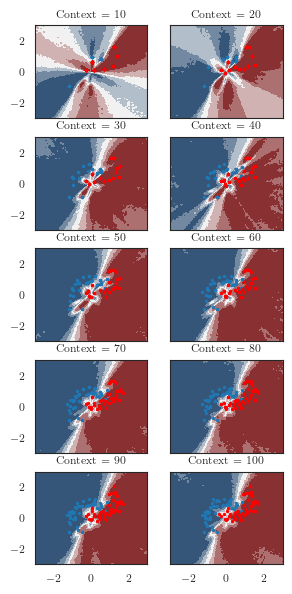

In [66]:

n_grps = len(angles)
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
D_H = 78
args = {"num_samples": 100, "num_chains": 1, "num_warmup": 200}
grid_3d = np.repeat(grid[None, ...], n_grps, axis=0)

accuracy_lst = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    Y_hierarchical_pred_train, Y_hierarchical_pred_test, ppc_grid, mcmc_hier = fit_and_eval(hierarchical_nn, X_train, X_test, Y_train, Y_test, grid_3d, D_H, args )
    # trace_hier = mcmc_hier.get_samples()

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        ppc_grid[:, -1, :].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    Y_hierarchical_pred_test = Y_hierarchical_pred_test.astype(int)
    # print(Y_hierarchical_pred_test[-1, :5], Y_test[-1, :5])
    acc = np.mean(Y_hierarchical_pred_test[-1, :] == Y_test[-1, :]) * n_samples
    print(f"accuracy {acc}")
    accuracy_lst.append(acc)
    X_plot = X_train[-1]
    Y_plot = Y_train[-1]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    # sns.despine()
    # axs[i].tick_params(axis='both', which='both', labelsize=3)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
# fig.legend(loc='upper center', fontsize=5, labels=['Class 0', 'Class 1'], bbox_to_anchor=(0.5, 0.04))
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_surface_large_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()
    


    

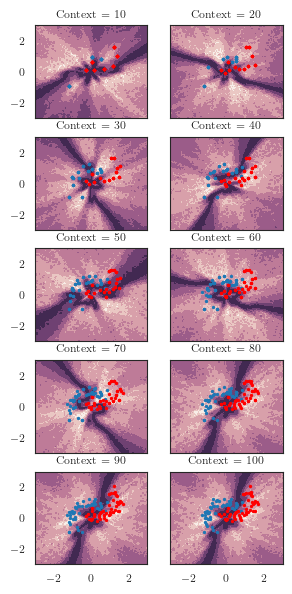

In [67]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    contour = axs[i].contourf(
        grid[:, 0].reshape((100, -1)),
        grid[:, 1].reshape((100, -1)),
        ppc_grid[:, i, :].std(axis=0).reshape(100, 100),
        cmap=cmap_uncertainty,
    )
    X_plot = contexts_x[i]
    Y_plot = contexts_y[i]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
    # sns.despine()
    # ax.legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_uncertainty_large_8angs.pdf", format="pdf", bbox_inches="tight")
plt.show()

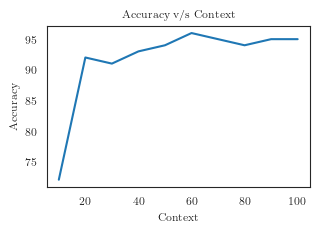

In [68]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig("comparison_plots/mm_hbnn_large_performance_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Medium Size model (10k param), h = 35

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:18<00:00,  3.83it/s, 511 steps of size 8.57e-03. acc. prob=0.89] 


accuracy 72.99999237060547
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:19<00:00,  3.78it/s, 511 steps of size 7.83e-03. acc. prob=0.73] 


accuracy 91.99999237060547
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:22<00:00,  3.64it/s, 511 steps of size 7.10e-03. acc. prob=0.94] 


accuracy 90.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:21<00:00,  3.69it/s, 511 steps of size 6.80e-03. acc. prob=0.93] 


accuracy 93.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:22<00:00,  3.64it/s, 511 steps of size 7.89e-03. acc. prob=0.92] 


accuracy 93.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:15<00:00,  3.97it/s, 511 steps of size 8.64e-03. acc. prob=0.89] 


accuracy 91.99999237060547
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:14<00:00,  4.01it/s, 511 steps of size 9.66e-03. acc. prob=0.88] 


accuracy 93.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s, 511 steps of size 7.18e-03. acc. prob=0.95] 


accuracy 91.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:16<00:00,  3.94it/s, 511 steps of size 9.11e-03. acc. prob=0.89] 


accuracy 94.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s, 511 steps of size 8.05e-03. acc. prob=0.91] 


accuracy 91.99999237060547


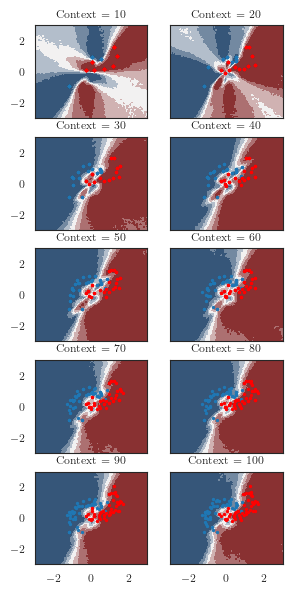

In [69]:

n_grps = len(angles)
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
D_H = 35
args = {"num_samples": 100, "num_chains": 1, "num_warmup": 200}
grid_3d = np.repeat(grid[None, ...], n_grps, axis=0)

accuracy_lst = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    Y_hierarchical_pred_train, Y_hierarchical_pred_test, ppc_grid, mcmc_hier = fit_and_eval(hierarchical_nn, X_train, X_test, Y_train, Y_test, grid_3d, D_H, args )
    # trace_hier = mcmc_hier.get_samples()

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        ppc_grid[:, -1, :].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    Y_hierarchical_pred_test = Y_hierarchical_pred_test.astype(int)
    # print(Y_hierarchical_pred_test[-1, :5], Y_test[-1, :5])
    acc = np.mean(Y_hierarchical_pred_test[-1, :] == Y_test[-1, :]) * n_samples
    print(f"accuracy {acc}")
    accuracy_lst.append(acc)
    X_plot = X_train[-1]
    Y_plot = Y_train[-1]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    # sns.despine()
    # axs[i].tick_params(axis='both', which='both', labelsize=3)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
# fig.legend(loc='upper center', fontsize=5, labels=['Class 0', 'Class 1'], bbox_to_anchor=(0.5, 0.04))
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_surface_medium_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()
    


    

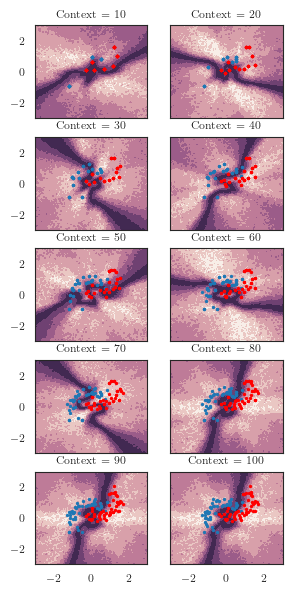

In [70]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    contour = axs[i].contourf(
        grid[:, 0].reshape((100, -1)),
        grid[:, 1].reshape((100, -1)),
        ppc_grid[:, i, :].std(axis=0).reshape(100, 100),
        cmap=cmap_uncertainty,
    )
    X_plot = contexts_x[i]
    Y_plot = contexts_y[i]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
    # sns.despine()
    # ax.legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_uncertainty_medium_8angs.pdf", format="pdf", bbox_inches="tight")
plt.show()

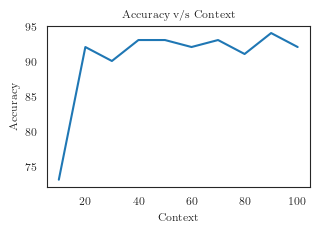

In [71]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig("comparison_plots/mm_hbnn_medium_performance_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Small (1k) = h = 10

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.15it/s, 511 steps of size 9.10e-03. acc. prob=0.88] 


accuracy 71.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:23<00:00, 13.04it/s, 511 steps of size 9.78e-03. acc. prob=0.92] 


accuracy 90.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.03it/s, 511 steps of size 1.01e-02. acc. prob=0.90] 


accuracy 91.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:20<00:00, 14.39it/s, 511 steps of size 9.52e-03. acc. prob=0.92] 


accuracy 90.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:20<00:00, 14.50it/s, 511 steps of size 9.92e-03. acc. prob=0.92] 


accuracy 88.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.28it/s, 511 steps of size 8.76e-03. acc. prob=0.93] 


accuracy 90.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:19<00:00, 15.40it/s, 511 steps of size 1.29e-02. acc. prob=0.82] 


accuracy 91.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:20<00:00, 14.58it/s, 511 steps of size 1.04e-02. acc. prob=0.86] 


accuracy 91.99999237060547
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:20<00:00, 14.63it/s, 511 steps of size 9.02e-03. acc. prob=0.90] 


accuracy 90.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.18it/s, 511 steps of size 9.06e-03. acc. prob=0.93] 


accuracy 91.99999237060547


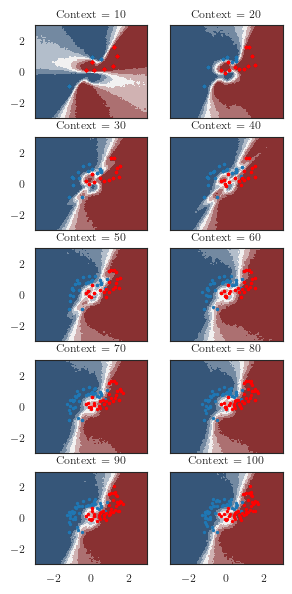

In [72]:

n_grps = len(angles)
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
D_H = 10
args = {"num_samples": 100, "num_chains": 1, "num_warmup": 200}
grid_3d = np.repeat(grid[None, ...], n_grps, axis=0)

accuracy_lst = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    Y_hierarchical_pred_train, Y_hierarchical_pred_test, ppc_grid, mcmc_hier = fit_and_eval(hierarchical_nn, X_train, X_test, Y_train, Y_test, grid_3d, D_H, args )
    # trace_hier = mcmc_hier.get_samples()

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        ppc_grid[:, -1, :].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    Y_hierarchical_pred_test = Y_hierarchical_pred_test.astype(int)
    # print(Y_hierarchical_pred_test[-1, :5], Y_test[-1, :5])
    acc = np.mean(Y_hierarchical_pred_test[-1, :] == Y_test[-1, :]) * n_samples
    print(f"accuracy {acc}")
    accuracy_lst.append(acc)
    X_plot = X_train[-1]
    Y_plot = Y_train[-1]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    # sns.despine()
    # axs[i].tick_params(axis='both', which='both', labelsize=3)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
# fig.legend(loc='upper center', fontsize=5, labels=['Class 0', 'Class 1'], bbox_to_anchor=(0.5, 0.04))
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_surface_small_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()
    


    

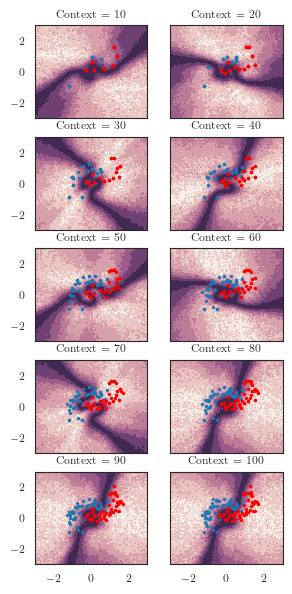

In [73]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    contour = axs[i].contourf(
        grid[:, 0].reshape((100, -1)),
        grid[:, 1].reshape((100, -1)),
        ppc_grid[:, i, :].std(axis=0).reshape(100, 100),
        cmap=cmap_uncertainty,
    )
    X_plot = contexts_x[i]
    Y_plot = contexts_y[i]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
    # sns.despine()
    # ax.legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_uncertainty_small_8angs.pdf", format="pdf", bbox_inches="tight")
plt.show()

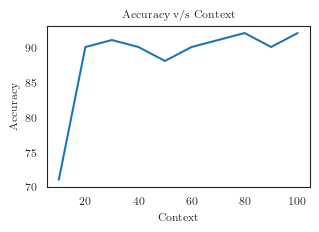

In [74]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig("comparison_plots/mm_hbnn_small_performance_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

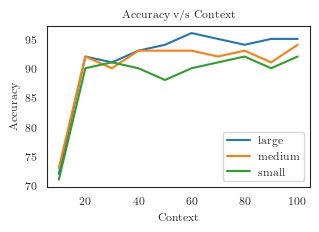

In [162]:
accuracy_lst_hbnn_large = [72, 92, 91, 93, 94, 96, 95, 94, 95, 95]
accuracy_lst_hbnn_medium = [73, 92, 90, 93, 93, 93, 92, 93, 91, 94]
accuracy_lst_hbnn_small = [71, 90, 91, 90, 88, 90, 91, 92, 90, 92]
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_hbnn_large) * n_samples/100, label = 'large')
plt.plot(context_points, np.array(accuracy_lst_hbnn_medium) * n_samples/100, label = 'medium')
plt.plot(context_points, np.array(accuracy_lst_hbnn_small) * n_samples/100, label = 'small')
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
plt.legend()
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_hbnn_performance_all_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# CNP

In [75]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.datasets import make_moons

In [76]:

# Function to rotate a dataset by a specified angle
def rotate_dataset(X, angle_degrees):
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                 [np.sin(angle_radians), np.cos(angle_radians)]])
    
    # Apply the rotation to the dataset
    rotated_X = X.dot(rotation_matrix)
    
    return rotated_X

In [77]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output




# Large Model 50k h = 112

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1322.91it/s]


predictions (100, 1), Y_test (100,)
89.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1342.35it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1289.41it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1302.05it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1365.38it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1360.95it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1368.18it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1367.28it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1363.46it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1363.45it/s]


predictions (100, 1), Y_test (100,)
99.0


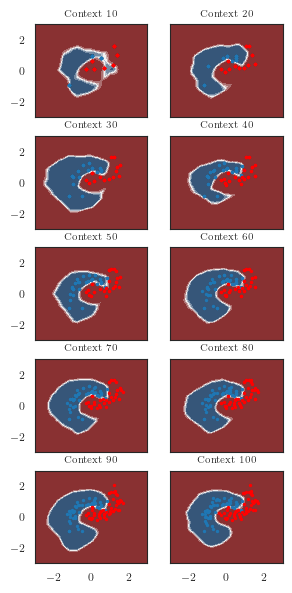

In [103]:

from sklearn.metrics import accuracy_score
def train_make_moons(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 100,  context_size = 10, target_size= 80):
    # model and loss initialization
    
    # encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    # decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]
    h = 112
    encoder_layout = [[3, h], [h, h], [h, h]]
    decoder_layout = [[h + 2,h], [h, h], [h, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 8) # possible values of index to look for 
        # print(context)

        if train_set == 7:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())
    
    # plt.plot(np.arange(len(losses)), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model



def testing(model, context_x, context_y, X_test, Y_test,  grid, context_size = 10, num_context = 10):
    target_x = X_test
    target_y = Y_test


    rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions >=0.5).int()
    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 2)
    predictions_grid = model(context_x, context_y, grid_tensor)
    predictions_grid = predictions_grid.detach().numpy()


    return predictions, predictions_grid


    
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T


accuracy_lst_cnp_large = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)


    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_make_moons(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=10000)
    predictions, predictions_grid = testing(model, contexts_x[i], contexts_y[i], X_test[-1], Y_test[-1], grid_3d[-1], context_points[i])
    print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")
    # acc = accuracy_lst.append()
    acc = accuracy_score(Y_test[-1],  predictions.reshape(100)) * 100
    # print(predictions)
    # acc = np.mean(Y_test[-1] == predictions.reshape(100)) * 100
    print(acc)
    accuracy_lst_cnp_large.append(acc)

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        predictions_grid.reshape(100, 100),
        cmap=cmap,
    )

    X = contexts_x[i]
    Y = contexts_y[i]
    axs[i].scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context {context_points[i]}", fontsize = 7)
    

    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
plt.savefig("comparison_plots/mm_cnp_surface_large_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()


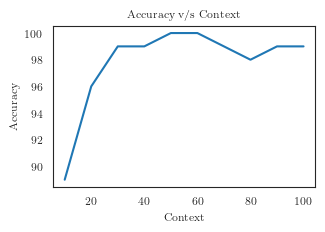

In [104]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_large) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_cnp_performance_large_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# medium 10K

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:06<00:00, 1660.65it/s]


predictions (100, 1), Y_test (100,)
81.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1675.31it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1677.71it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1679.00it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:06<00:00, 1665.98it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1671.54it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1684.94it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:06<00:00, 1656.62it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:06<00:00, 1654.79it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:05<00:00, 1674.76it/s]


predictions (100, 1), Y_test (100,)
98.0


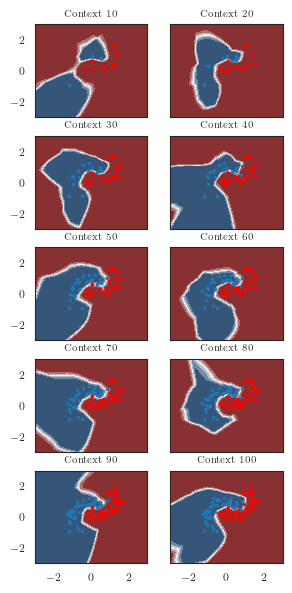

In [130]:

from sklearn.metrics import accuracy_score
def train_make_moons(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 100,  context_size = 20, target_size= 80):
    # model and loss initialization
    
    # encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    # decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]
    h = 50
    encoder_layout = [[3, h], [h, h], [h, h]]
    decoder_layout = [[h + 2,h], [h, h], [h, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 8) # possible values of index to look for 
        # print(context)

        if train_set == 7:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())
    
    # plt.plot(np.arange(len(losses)), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model



def testing(model, context_x, context_y, X_test, Y_test,  grid, context_size = 30, num_context = 10):
    target_x = X_test
    target_y = Y_test


    rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    # rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions >=0.5).int()
    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 2)
    predictions_grid = model(context_x, context_y, grid_tensor)
    predictions_grid = predictions_grid.detach().numpy()


    return predictions, predictions_grid


    
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T


accuracy_lst_cnp_medium = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)


    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_make_moons(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=10000)
    predictions, predictions_grid = testing(model, contexts_x[i], contexts_y[i], X_test[-1], Y_test[-1], grid_3d[-1], context_points[i])
    print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")
    # acc = accuracy_lst.append()
    acc = accuracy_score(Y_test[-1],  predictions.reshape(100)) * 100
    # print(predictions)
    # acc = np.mean(Y_test[-1] == predictions.reshape(100)) * 100
    print(acc)
    accuracy_lst_cnp_medium.append(acc)

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        predictions_grid.reshape(100, 100),
        cmap=cmap,
    )

    X = contexts_x[i]
    Y = contexts_y[i]
    axs[i].scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context {context_points[i]}", fontsize = 7)
    

    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
plt.savefig("comparison_plots/mm_cnp_surface_medium_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()


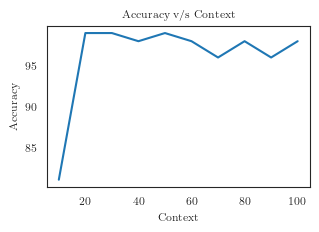

In [131]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_medium) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_cnp_performance_medium_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# small parameters 1k h = 16

(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1895.02it/s]


predictions (100, 1), Y_test (100,)
80.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1898.42it/s]


predictions (100, 1), Y_test (100,)
88.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1906.97it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1901.03it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1901.40it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1897.89it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1893.49it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1899.35it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1901.52it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 2) (8, 100, 2) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1897.38it/s]


predictions (100, 1), Y_test (100,)
98.0


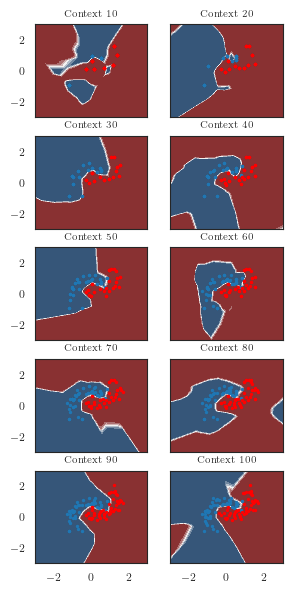

In [157]:

from sklearn.metrics import accuracy_score
def train_make_moons(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 100,  context_size = 30, target_size= 80):
    # model and loss initialization
    
    # encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    # decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]
    h = 16
    encoder_layout = [[3, h], [h, h], [h, h]]
    decoder_layout = [[h + 2,h], [h, h], [h, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 8) # possible values of index to look for 
        # print(context)

        if train_set == 7:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())
    
    # plt.plot(np.arange(len(losses)), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model



def testing(model, context_x, context_y, X_test, Y_test,  grid, context_size = 30, num_context = 10):
    target_x = X_test
    target_y = Y_test


    rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    # rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions >=0.5).int()
    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 2)
    predictions_grid = model(context_x, context_y, grid_tensor)
    predictions_grid = predictions_grid.detach().numpy()


    return predictions, predictions_grid


    
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T


accuracy_lst_cnp_small = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples, 2)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples, 2) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)


    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_make_moons(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=100000)
    predictions, predictions_grid = testing(model, contexts_x[i], contexts_y[i], X_test[-1], Y_test[-1], grid_3d[-1], context_points[i])
    print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")
    # acc = accuracy_lst.append()
    acc = accuracy_score(Y_test[-1],  predictions.reshape(100)) * 100
    # print(predictions)
    # acc = np.mean(Y_test[-1] == predictions.reshape(100)) * 100
    print(acc)
    accuracy_lst_cnp_small.append(acc)

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        predictions_grid.reshape(100, 100),
        cmap=cmap,
    )

    X = contexts_x[i]
    Y = contexts_y[i]
    axs[i].scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context {context_points[i]}", fontsize = 7)
    

    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
plt.savefig("comparison_plots/mm_cnp_surface_small_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()


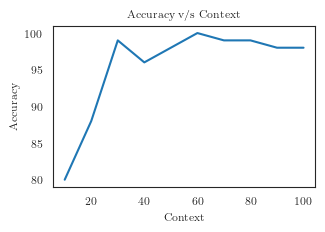

In [158]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_small) * n_samples/100)
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_cnp_performance_small_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

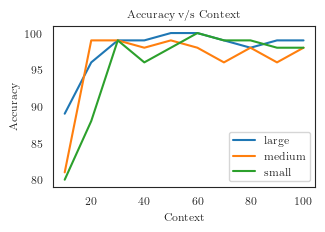

In [160]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_large) * n_samples/100, label = 'large')
plt.plot(context_points, np.array(accuracy_lst_cnp_medium) * n_samples/100, label = 'medium')
plt.plot(context_points, np.array(accuracy_lst_cnp_small) * n_samples/100, label = 'small')
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
plt.legend()
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_cnp_performance_all_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

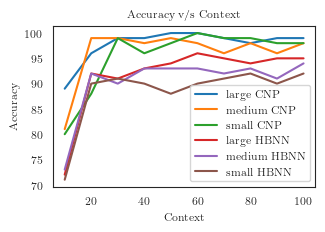

In [163]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_large) * n_samples/100, label = 'large CNP')
plt.plot(context_points, np.array(accuracy_lst_cnp_medium) * n_samples/100, label = 'medium CNP')
plt.plot(context_points, np.array(accuracy_lst_cnp_small) * n_samples/100, label = 'small CNP')

plt.plot(context_points, np.array(accuracy_lst_hbnn_large) * n_samples/100, label = 'large HBNN' )
plt.plot(context_points, np.array(accuracy_lst_hbnn_medium) * n_samples/100, label = 'medium HBNN')
plt.plot(context_points, np.array(accuracy_lst_hbnn_small) * n_samples/100, label = 'small HBNN')

plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
plt.legend()
ax.tick_params(axis='both', which='both')
plt.savefig("comparison_plots/mm_cnp_hbnn_performance_all_8ang.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Additional Parameter, sin of the angles


### HBNN

In [164]:
contexts_x.shape, contexts_y.shape, X_test_data.shape, Y_test_data.shape, X_train_data.shape, Y_train_data.shape, angle_param.shape


((10, 100, 2), (10, 100), (100, 2), (100,), (7, 100, 2), (7, 100), (8, 100, 1))

In [191]:
angles_ = np.array(angles, dtype=float)
sin_angles = np.sin(angles_ * np.pi / 180) 
contexts_x_param = []
X_test_data_param = []
for i in range(len(context_points)):
    contexts_x_param.append(np.concatenate((contexts_x[i], sin_angles[-1] * np.ones([n_samples, 1]) ), axis=1))

X_test_data_param = np.concatenate((X_test_data, sin_angles[-1] * np.ones([n_samples, 1]) ), axis=1)

X_train_data_param = []
for i in range(len(angles) - 1):
    X_train_data_param.append(np.concatenate((X_train_data[i], sin_angles[i] * np.ones([n_samples, 1]) ), axis=1))



contexts_x_param = np.array(contexts_x_param)
X_train_data_param = np.array(X_train_data_param)


In [192]:
contexts_x_param.shape, contexts_y.shape, X_test_data_param.shape, Y_test_data.shape, X_train_data_param.shape, Y_train_data.shape


((10, 100, 3), (10, 100), (100, 3), (100,), (7, 100, 3), (7, 100))

In [36]:
# def rotate(X, deg):
#     theta = np.radians(deg)
#     c, s = np.cos(theta), np.sin(theta)
#     R = np.matrix([[c, -s], [s, c]])
#     X = X.dot(R)

#     return np.asarray(X)

# context_points = list(range(10, 101, 10))
# # context_points = [10, 20]

# n_samples = 100
# angles = [0, 45, 90, 135, 180, 225, 270, 315]

# noise = 0.2

# # fixed points
# X_train_data, Y_train_data = [], []
# X_test_data, Y_test_data = [], []
# for i in range(len(angles)):
#     xx, yy = make_moons(n_samples=n_samples, noise= noise)
#     rotate_by = angles[i]
#     rotated_data = rotate(xx, rotate_by)
#     rotated_data = np.concatenate((rotated_data, np.sin(angles[i]*np.ones([n_samples, 1]))), axis=1)
#     if i == len(angles) - 1:
#         X_test_data = rotated_data
#         Y_test_data = yy
#     else :
#         X_train_data.append(rotated_data)
#         Y_train_data.append(yy)

# # different context
# contexts_x, contexts_y = [], []
# for contexts in context_points:
#     x_new = np.tile(X_test_data[: contexts], (n_samples//contexts +1, 1))
#     y_new = np.tile(Y_test_data[: contexts], n_samples//contexts + 1)
#     x_new = x_new[: n_samples, :]
#     y_new = y_new[: n_samples]
#     contexts_x.append(x_new)
#     contexts_y.append(y_new)

# contexts_y = np.array(contexts_y)
# contexts_x = np.array(contexts_x)
# X_train_data = np.array(X_train_data)
# Y_train_data = np.array(Y_train_data)
# X_test_data = np.array(X_test_data)
# Y_test_data = np.array(Y_test_data)


# D_Y = 1 # output dim
# D_C = len(angles) # different tasks
# D_X = 3 # input dimensions

In [200]:
"""
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
"""


def hierarchical_nn(X, Y, D_H ):
    # D_C, _, D_X = X.shape
    # D_Y = 1

    D_Y = 1 # output dim
    D_C = 8 # different tasks
    D_X = 3 # input dimensions
    # print(X.shape)
    # Group mean distribution for input to hidden layer
    mu_1= numpyro.sample("mu_1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    sigma_1 = numpyro.sample("sigma_1", dist.HalfNormal(1.0))

    # sample second layer
    mu_2 = numpyro.sample("mu_2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    sigma_2 = numpyro.sample("sigma_2", dist.HalfNormal(1.0))

    # sample final layer of weights and neural network output
    mu_3 = numpyro.sample("mu_3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    sigma_3 = numpyro.sample("sigma_3", dist.HalfNormal(1.0))

    w1_all = numpyro.sample("w1_all", dist.Normal(jnp.zeros((D_C, D_X, D_H)), jnp.ones((D_C, D_X, D_H))))  # D_C D_X D_H
    w2_all = numpyro.sample("w2_all", dist.Normal(jnp.zeros((D_C, D_H, D_H)), jnp.ones((D_C, D_H, D_H))))  # D_C D_H D_H
    w3_all = numpyro.sample("w3_all", dist.Normal(jnp.zeros((D_C, D_H, D_Y)), jnp.ones((D_C, D_H, D_Y))))  # D_C D_H D_Y

    w1 = w1_all * sigma_1 + mu_1
    w2 = w2_all * sigma_2 + mu_2
    w3 = w3_all * sigma_3 + mu_3
    # print(f"shape - w1 w2 w3 {w1.shape, w2.shape, w3.shape}") # w1 shape = D_C * D_X * D_H
    # print(f"x shape {X.shape}")
    z1 = jnp.tanh(jnp.matmul(X, w1))  # D_C N D_H  <= first layer of activations
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # D_C N D_H  <= second layer of activations
    z3 = jnp.matmul(z2, w3)  # D_C N D_Y  <= output of the neural network

    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y.reshape((D_C, -1, 1)) if Y is not None else Y)


In [202]:
def run_inference(model, rng_key, args, **kwargs):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        progress_bar=True,
    )
    mcmc.run(rng_key, **kwargs)
    return mcmc

def get_predictions(model, rng_key, samples, X, D_H, args, bnn_kwargs):
    # helper function for prediction
    def predict(model, rng_key, samples, X, D_H, bnn_kwargs):
        model = handlers.substitute(handlers.seed(model, rng_key), samples)
        # note that Y will be sampled in the model because we pass Y=None here
        model_trace = (
            handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
            if bnn_kwargs is None
            else handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H, **bnn_kwargs)
        )
        return model_trace["Y"]["value"]

    # predict Y at inputs X
    vmap_args = (samples, random.split(rng_key, args["num_samples"] * args["num_chains"]))
    predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H, bnn_kwargs))(*vmap_args)
    return predictions

def get_mean_predictions(predictions, threshold=0.5):
    predictions = predictions[..., 0]
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold


def fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args, bnn_kwargs=None):
    # values to be returned
    pred_train, pred_test, pred_grid = [], [], []

    # do inference
    kwargs = {"X": X_train, "Y": Y_train, "D_H": D_H}
    if bnn_kwargs:
        kwargs = {**kwargs, **bnn_kwargs}

    rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
    mcmc = run_inference(model, rng_key, args, **kwargs)
    samples = mcmc.get_samples()

    # predict Y_train and Y_test at inputs X_traind and X_test, respectively
    predictions = get_predictions(model, rng_key_train, samples, X_train, D_H, args, bnn_kwargs)
    # print(f"prediction test {predictions.shape}")
    mean_prediction = get_mean_predictions(predictions)
    # print(f"test mean predictions {mean_prediction.shape}")
    pred_train = mean_prediction

    predictions = get_predictions(model, rng_key_test, samples, X_test, D_H, args, bnn_kwargs)
    mean_prediction = get_mean_predictions(predictions)
    pred_test = mean_prediction

    ppc_grid = get_predictions(model, rng_key_grid, samples, grid, D_H, args, bnn_kwargs)
    return pred_train, pred_test, ppc_grid, mcmc


In [208]:
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid = np.concatenate((grid, sin_angles[-1]*np.ones([10000, 1])), axis=1)
grid_3d_2param = np.repeat(grid[None, ...], n_grps, axis=0)
grid_3d_2param.shape

(8, 10000, 3)

(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 13.99it/s, 511 steps of size 1.01e-02. acc. prob=0.92] 


accuracy 91.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:24<00:00, 12.40it/s, 511 steps of size 9.26e-03. acc. prob=0.93] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 13.82it/s, 511 steps of size 1.10e-02. acc. prob=0.92] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.24it/s, 511 steps of size 9.82e-03. acc. prob=0.95] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 13.76it/s, 511 steps of size 1.30e-02. acc. prob=0.85] 


accuracy 100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 13.72it/s, 511 steps of size 9.68e-03. acc. prob=0.95] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:20<00:00, 14.84it/s, 511 steps of size 9.32e-03. acc. prob=0.95] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.00it/s, 511 steps of size 1.02e-02. acc. prob=0.92] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:22<00:00, 13.50it/s, 511 steps of size 7.70e-03. acc. prob=0.95] 


accuracy 98.99999237060547
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


sample: 100%|██████████| 300/300 [00:21<00:00, 14.12it/s, 511 steps of size 1.19e-02. acc. prob=0.90] 


accuracy 97.99999237060547


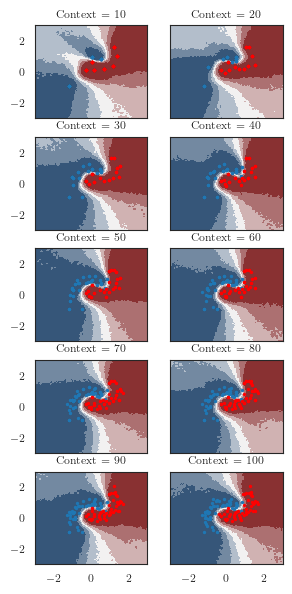

In [210]:

n_grps = len(angles)
D_H = 10
args = {"num_samples": 100, "num_chains": 1, "num_warmup": 200}


accuracy_lst_hbnn_small_2param = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    X_train = np.concatenate( (X_train_data_param, contexts_x_param[i].reshape(1, n_samples, 3)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data_param, X_test_data_param.reshape(1, n_samples, 3) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    Y_hierarchical_pred_train, Y_hierarchical_pred_test, ppc_grid, mcmc_hier = fit_and_eval(hierarchical_nn, X_train, X_test, Y_train, Y_test, grid_3d_2param, D_H, args )
    # trace_hier = mcmc_hier.get_samples()

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        ppc_grid[:, -1, :].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    Y_hierarchical_pred_test = Y_hierarchical_pred_test.astype(int)
    # print(Y_hierarchical_pred_test[-1, :5], Y_test[-1, :5])
    acc = np.mean(Y_hierarchical_pred_test[-1, :] == Y_test[-1, :]) * n_samples
    print(f"accuracy {acc}")
    accuracy_lst_hbnn_small_2param.append(acc)
    X_plot = X_train[-1]
    Y_plot = Y_train[-1]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    # sns.despine()
    # axs[i].tick_params(axis='both', which='both', labelsize=3)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
# fig.legend(loc='upper center', fontsize=5, labels=['Class 0', 'Class 1'], bbox_to_anchor=(0.5, 0.04))
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_surface_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()
    


    

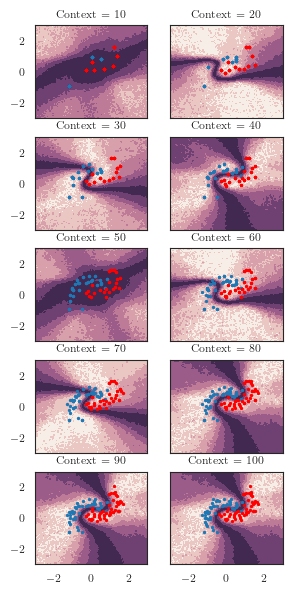

In [212]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    contour = axs[i].contourf(
        grid[:, 0].reshape((100, -1)),
        grid[:, 1].reshape((100, -1)),
        ppc_grid[:, i, :].std(axis=0).reshape(100, 100),
        cmap=cmap_uncertainty,
    )
    X_plot = contexts_x[i]
    Y_plot = contexts_y[i]
    axs[i].scatter(X_plot[Y_plot == 0, 0], X_plot[Y_plot == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X_plot[Y_plot == 1, 0], X_plot[Y_plot == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context = {context_points[i]}", fontsize = 8)
    # sns.despine()
    # ax.legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=8)
plt.savefig("comparison_plots/mm_hbnn_uncertainty_small_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()

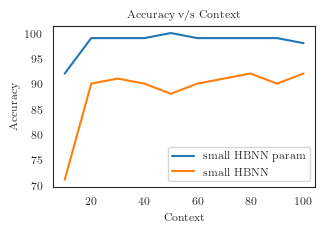

In [211]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_hbnn_small_2param) * n_samples/100, label = 'small HBNN param')
plt.plot(context_points, np.array(accuracy_lst_hbnn_small) * n_samples/100, label = 'small HBNN')
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.legend()
plt.savefig("comparison_plots/mm_hbnn_small_performance_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()

### CNP

In [213]:

# Function to rotate a dataset by a specified angle
def rotate_dataset(X, angle_degrees):
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                 [np.sin(angle_radians), np.cos(angle_radians)]])
    
    # Apply the rotation to the dataset
    rotated_X = X.dot(rotation_matrix)
    
    return rotated_X

In [223]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output




(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1188.97it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1159.26it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1168.34it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1193.83it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1114.96it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1144.35it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1132.54it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1150.09it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:08<00:00, 1213.44it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 10000/10000 [00:07<00:00, 1275.45it/s]


predictions (100, 1), Y_test (100,)
100.0


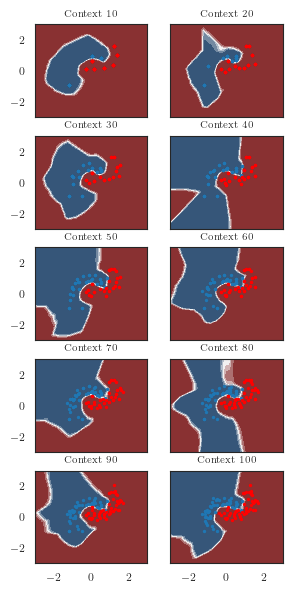

In [224]:

from sklearn.metrics import accuracy_score
def train_make_moons(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 100,  context_size = 20, target_size= 80):
    # model and loss initialization
    
    # encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    # decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]
    h = 112
    encoder_layout = [[4, h], [h, h], [h, h]]
    decoder_layout = [[h + 3,h], [h, h], [h, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 8) # possible values of index to look for 
        # print(context)

        if train_set == 7:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())
    
    # plt.plot(np.arange(len(losses)), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model



def testing(model, context_x, context_y, X_test, Y_test,  grid, context_size = 30, num_context = 10):
    target_x = X_test
    target_y = Y_test


    rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    # rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions >=0.5).int()
    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 3)
    predictions_grid = model(context_x, context_y, grid_tensor)
    predictions_grid = predictions_grid.detach().numpy()


    return predictions, predictions_grid


    
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid = np.concatenate((grid, np.sin(angles[-1])*np.ones([10000, 1])), axis=1)
# print(grid.shape)

accuracy_lst_cnp_large_2param = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data_param, contexts_x_param[i].reshape(1, n_samples, 3)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data_param, X_test_data_param.reshape(1, n_samples, 3) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_make_moons(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=10000)
    predictions, predictions_grid = testing(model, contexts_x_param[i], contexts_y[i], X_test[-1], Y_test[-1], grid_3d_2param[-1], context_points[i])
    print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")
    # acc = accuracy_lst.append()
    acc = accuracy_score(Y_test[-1],  predictions.reshape(100)) * 100
    # print(predictions)
    # acc = np.mean(Y_test[-1] == predictions.reshape(100)) * 100
    print(acc)
    accuracy_lst_cnp_large_2param.append(acc)

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        predictions_grid.reshape(100, 100),
        cmap=cmap,
    )

    X = contexts_x[i]
    Y = contexts_y[i]
    axs[i].scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context {context_points[i]}", fontsize = 7)
    

    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
plt.savefig("comparison_plots/mm_cnp_surface_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()


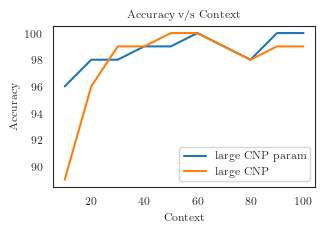

In [227]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_large_2param) * n_samples/100, label = 'large CNP param')
plt.plot(context_points, np.array(accuracy_lst_cnp_large) * n_samples/100, label = 'large CNP')
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.legend()
plt.savefig("comparison_plots/mm_cnp_large_performance_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()

(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:54<00:00, 1841.28it/s]


predictions (100, 1), Y_test (100,)
89.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1899.61it/s]


predictions (100, 1), Y_test (100,)
91.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:52<00:00, 1920.28it/s]


predictions (100, 1), Y_test (100,)
96.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1924.27it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1938.03it/s]


predictions (100, 1), Y_test (100,)
98.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1930.82it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1934.69it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1923.84it/s]


predictions (100, 1), Y_test (100,)
99.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1927.66it/s]


predictions (100, 1), Y_test (100,)
100.0
(8, 100, 3) (8, 100, 3) (8, 100) (8, 100)


100%|██████████| 100000/100000 [00:51<00:00, 1945.96it/s]


predictions (100, 1), Y_test (100,)
98.0


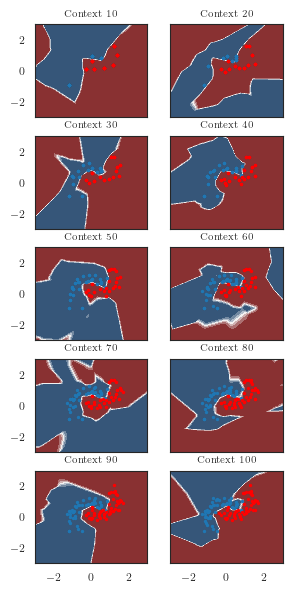

In [226]:

from sklearn.metrics import accuracy_score
def train_make_moons(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 100,  context_size = 30, target_size= 80):
    # model and loss initialization
    
    # encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    # decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]
    h = 16
    encoder_layout = [[4, h], [h, h], [h, h]]
    decoder_layout = [[h + 3,h], [h, h], [h, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 8) # possible values of index to look for 
        # print(context)

        if train_set == 7:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())
    
    # plt.plot(np.arange(len(losses)), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model



def testing(model, context_x, context_y, X_test, Y_test,  grid, context_size = 30, num_context = 10):
    target_x = X_test
    target_y = Y_test


    rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    # rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions >=0.5).int()
    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 3)
    predictions_grid = model(context_x, context_y, grid_tensor)
    predictions_grid = predictions_grid.detach().numpy()


    return predictions, predictions_grid


    
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid = np.concatenate((grid, np.sin(angles[-1])*np.ones([10000, 1])), axis=1)
# print(grid.shape)

accuracy_lst_cnp_small_2param = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data_param, contexts_x_param[i].reshape(1, n_samples, 3)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data_param, X_test_data_param.reshape(1, n_samples, 3) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_make_moons(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=100000)
    predictions, predictions_grid = testing(model, contexts_x_param[i], contexts_y[i], X_test[-1], Y_test[-1], grid_3d_2param[-1], context_points[i])
    print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")
    # acc = accuracy_lst.append()
    acc = accuracy_score(Y_test[-1],  predictions.reshape(100)) * 100
    # print(predictions)
    # acc = np.mean(Y_test[-1] == predictions.reshape(100)) * 100
    print(acc)
    accuracy_lst_cnp_small_2param.append(acc)

    contour = axs[i].contourf(
        grid[:, 0].reshape((100, 100)),
        grid[:, 1].reshape((100, 100)),
        predictions_grid.reshape(100, 100),
        cmap=cmap,
    )

    X = contexts_x[i]
    Y = contexts_y[i]
    axs[i].scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0", s = 2)
    axs[i].scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s= 2)
    axs[i].set_title(f"Context {context_points[i]}", fontsize = 7)
    

    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
plt.savefig("comparison_plots/mm_cnp_surface_small_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()


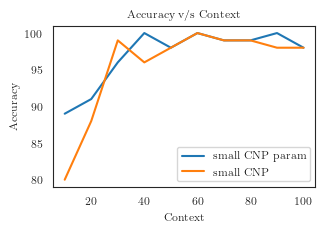

In [228]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.array(accuracy_lst_cnp_small_2param) * n_samples/100, label = 'small CNP param')
plt.plot(context_points, np.array(accuracy_lst_cnp_small) * n_samples/100, label = 'small CNP')
plt.title("Accuracy v/s Context")
plt.xlabel("Context")
plt.ylabel("Accuracy")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.legend()
plt.savefig("comparison_plots/mm_cnp_small_performance_2param.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Rough

In [ ]:
# import numpy as np

# # Create a NumPy array
# arr = np.random.randint(1, 1000, size=[3, 5, 6]) * 0.4

# print(arr)
# # Save the array to a binary file
# np.save('myarray.npy', arr)
# # Load the saved array
# arr_loaded = np.load('myarray.npy')
# print(arr_loaded)

# def f1(h):
#     return 8*(3*h + h*h)

# def f2(h):
#     return 6*h + 4*h*h

# f1(10), f2(16) 1k
# f1(35), f2(50) 10k
# f1(78), f2(112) 50k